# Fraud Detection for Automobile Claims: Mitigate Bias, Train, Register, and Deploy Unbiased Model

## Background

This notebook is the fourth part of a series of notebooks that will demonstrate how to prepare, train, and deploy a model that detects fradulent auto claims. In this notebook, we will describe how to detect bias using Clarify, mitigate it with SMOTE, train another model, put it in the Model Registry along with all the Lineage of the Artifacts created along the way: data, code and model metadata. You can choose to run this notebook by itself or in sequence with the other notebooks listed below. Please see the [README.md](README.md) for more information about this use case implemented by this series of notebooks. 


1. [Fraud Detection for Automobile Claims: Data Exploration](./0-AutoClaimFraudDetection.ipynb)
1. [Fraud Detection for Automobile Claims: Data Preparation, Process, and Store Features](./1-data-prep-e2e.ipynb)
1. [Fraud Detection for Automobile Claims: Train, Check Bias, Tune, Record Lineage, and Register a Model](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb)
1. **[Fraud Detection for Automobile Claims: Mitigate Bias, Train, Register, and Deploy Unbiased Model](./3-mitigate-bias-train-model2-registry-e2e.ipynb)**


## Contents
1. [Architecture: Train, Check Bias, Tune, Record Lineage, Register Model](#Architecture:-Train,-Check-Bias,-Tune,-Record-Lineage,-Register-Model)
1. [Develop an Unbiased Model](#Develop-an-Unbiased-Model)
1. [Analyze Model for Bias and Explainability](#Analyze-Model-for-Bias-and-Explainability)
1. [View Results of Clarify Job](#View-Results-of-Clarify-Job)
1. [Configure and Run Explainability Job](#Configure-and-Run-Explainability-Job)
1. [Create Model Package for the Trained Model](#Create-Model-Package-for-the-Trained-Model)
1. [Architecture: Deploy and Serve Model](#Architecture:-Deploy-and-Serve-Model)
1. [Deploy an Approved Model](#Deploy-an-Approved-Model)
1. [Run Predictions on Claims](#Run-Predictions-on-Claims)

### Install required and/or update third-party libraries

In [1]:
!python -m pip install -Uq pip
!python -m pip install -q awswrangler==2.2.0 imbalanced-learn==0.7.0 sagemaker==2.23.0 boto3==1.17.70

### Import libraries

In [2]:
import json
import time
import boto3
import sagemaker
import numpy as np
import pandas as pd
import awswrangler as wr
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sagemaker.xgboost.estimator import XGBoost

from model_package_src.inference_specification import InferenceSpecification

%matplotlib inline

### Set region, boto3 and SageMaker SDK variables

In [3]:
# You can change this to a region of your choice
import sagemaker

region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

Using AWS Region: us-east-1


In [4]:
boto3.setup_default_session(region_name=region)

boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")

sagemaker_session = sagemaker.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)

sagemaker_role = sagemaker.get_execution_role()

account_id = boto3.client("sts").get_caller_identity()["Account"]

In [5]:
# variables used for parameterizing the notebook run
bucket = sagemaker_session.default_bucket()
prefix = "fraud-detect-demo"

claims_fg_name = f"{prefix}-claims"
customers_fg_name = f"{prefix}-customers"

model_2_name = f"{prefix}-xgboost-post-smote"

train_data_upsampled_s3_path = f"s3://{bucket}/{prefix}/data/train/upsampled/train.csv"
bias_report_2_output_path = f"s3://{bucket}/{prefix}/clarify-output/bias-2"
explainability_output_path = f"s3://{bucket}/{prefix}/clarify-output/explainability"

train_instance_count = 1
train_instance_type = "ml.m4.xlarge"

claify_instance_count = 1
clairfy_instance_type = "ml.c5.xlarge"

## Architecture: Train, Check Bias, Tune, Record Lineage, Register Model
----

![train-assess-tune-register](./images/e2e-2-pipeline-v3b.png)

## Develop an Unbiased Model
----

In this second model, you will fix the gender imbalance in the dataset using SMOTE and train another model using XGBoost. This model will also be saved to our registry and eventually approved for deployment.

In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

<a id='smote'></a>

### Resolve class imbalance using SMOTE

To handle the imbalance, we can over-sample (i.e. upsample) the minority class using [SMOTE (Synthetic Minority Over-sampling Technique)](https://arxiv.org/pdf/1106.1813.pdf). After installing the imbalanced-learn module, if you receive an ImportError when importing SMOTE, then try restarting the kernel. 

#### Gender balance before SMOTE

In [7]:
gender = train["customer_gender_female"]
gender.value_counts()

0    2778
1    1222
Name: customer_gender_female, dtype: int64

#### Gender balance after SMOTE

In [8]:
sm = SMOTE(random_state=42)
train_data_upsampled, gender_res = sm.fit_resample(train, gender)
train_data_upsampled["customer_gender_female"].value_counts()

1    2778
0    2778
Name: customer_gender_female, dtype: int64

### Set the hyperparameters
These are the parameters which will be sent to our training script in order to train the model. Although they are all defined as "hyperparameters" here, they can encompass XGBoost's [Learning Task Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters), [Tree Booster Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster), or any other parameters you'd like to configure for XGBoost.

In [9]:
hyperparameters = {
    "max_depth": "3",
    "eta": "0.2",
    "objective": "binary:logistic",
    "num_round": "100",
}

### Train new model


In [10]:
train_data_upsampled.to_csv("data/upsampled_train.csv", index=False)
s3_client.upload_file(
    Filename="data/upsampled_train.csv",
    Bucket=bucket,
    Key=f"{prefix}/data/train/upsampled/train.csv",
)

In [11]:
xgb_estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    hyperparameters=hyperparameters,
    role=sagemaker_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    framework_version="1.0-1",
)

In [12]:
if "training_job_2_name" not in locals():

    xgb_estimator.fit(inputs={"train": train_data_upsampled_s3_path})
    training_job_2_name = xgb_estimator.latest_training_job.job_name

else:

    print(f"Using previous training job: {training_job_2_name}")

2022-10-03 16:27:33 Starting - Starting the training job...ProfilerReport-1664814453: InProgress
...
2022-10-03 16:28:25 Starting - Preparing the instances for training.........
2022-10-03 16:29:45 Downloading - Downloading input data...
2022-10-03 16:30:27 Training - Downloading the training image......
2022-10-03 16:31:33 Uploading - Uploading generated training modelINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module xgboost_starter_script does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processing /opt/ml/code
  Created wheel for xgboost-starter-script: filename=xgboost

### Register artifacts

In [13]:
training_job_2_info = sagemaker_boto_client.describe_training_job(
    TrainingJobName=training_job_2_name
)

#### Code artifact

In [14]:
# return any existing artifact which match the our training job's code arn
code_s3_uri = training_job_2_info["HyperParameters"]["sagemaker_submit_directory"]

list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=code_s3_uri, sagemaker_session=sagemaker_session
    )
)

# use existing arifact if it's already been created, otherwise create a new artifact
if list_response:
    code_artifact = list_response[0]
    print(f"Using existing artifact: {code_artifact.artifact_arn}")
else:
    code_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingScript",
        source_uri=code_s3_uri,
        artifact_type="Code",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {code_artifact.artifact_arn}: SUCCESSFUL")

Create artifact arn:aws:sagemaker:us-east-1:326383828736:artifact/125408cd8e818dd01d3c894a15d4eb94: SUCCESSFUL


#### Training data artifact

In [15]:
training_data_s3_uri = training_job_2_info["InputDataConfig"][0]["DataSource"]["S3DataSource"][
    "S3Uri"
]

list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=training_data_s3_uri, sagemaker_session=sagemaker_session
    )
)

if list_response:
    training_data_artifact = list_response[0]
    print(f"Using existing artifact: {training_data_artifact.artifact_arn}")
else:
    training_data_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingData",
        source_uri=training_data_s3_uri,
        artifact_type="Dataset",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:326383828736:artifact/710d0367d915cad94ecbe63301ebfee0


#### Model artifact

In [16]:
trained_model_s3_uri = training_job_2_info["ModelArtifacts"]["S3ModelArtifacts"]

list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=trained_model_s3_uri, sagemaker_session=sagemaker_session
    )
)

if list_response:
    model_artifact = list_response[0]
    print(f"Using existing artifact: {model_artifact.artifact_arn}")
else:
    model_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainedModel",
        source_uri=trained_model_s3_uri,
        artifact_type="Model",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {model_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:326383828736:artifact/42734cfca1cabc6f4b290cbe7ae9cdbc


### Set artifact associations

In [17]:
trial_component = sagemaker_boto_client.describe_trial_component(
    TrialComponentName=training_job_2_name + "-aws-training-job"
)
trial_component_arn = trial_component["TrialComponentArn"]

#### Input artifacts

In [18]:
input_artifacts = [code_artifact, training_data_artifact]

for a in input_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="ContributedTo",
            sagemaker_session=sagemaker_session,
        )
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Associate arn:aws:sagemaker:us-east-1:326383828736:experiment-trial-component/sagemaker-xgboost-2022-10-03-16-27-33-159-aws-training-job and arn:aws:sagemaker:us-east-1:326383828736:artifact/125408cd8e818dd01d3c894a15d4eb94: SUCCEESFUL

Association already exists between arn:aws:sagemaker:us-east-1:326383828736:experiment-trial-component/sagemaker-xgboost-2022-10-03-16-27-33-159-aws-training-job and arn:aws:sagemaker:us-east-1:326383828736:artifact/710d0367d915cad94ecbe63301ebfee0.



#### Output artifacts

In [19]:
output_artifacts = [model_artifact]

for artifact_arn in output_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="Produced",
            sagemaker_session=sagemaker_session,
        )
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Association already exists between arn:aws:sagemaker:us-east-1:326383828736:experiment-trial-component/sagemaker-xgboost-2022-10-03-16-27-33-159-aws-training-job and arn:aws:sagemaker:us-east-1:326383828736:artifact/710d0367d915cad94ecbe63301ebfee0.



## Analyze Model for Bias and Explainability
----

Amazon SageMaker Clarify provides tools to help explain how machine learning (ML) models make predictions. These tools can help ML modelers and developers and other internal stakeholders understand model characteristics as a whole prior to deployment and to debug predictions provided by the model after it's deployed. Transparency about how ML models arrive at their predictions is also critical to consumers and regulators who need to trust the model predictions if they are going to accept the decisions based on them. SageMaker Clarify uses a model-agnostic feature attribution approach, which you can used to understand why a model made a prediction after training and to provide per-instance explanation during inference. The implementation includes a scalable and efficient implementation of SHAP ([see paper](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)), based on the concept of a Shapley value from the field of cooperative game theory that assigns each feature an importance value for a particular prediction. 

### Create model from estimator

In [20]:
def delete_model_if_exists(sagemaker_session, model_name):
    try:
        model_exists = sagemaker_session.describe_model(model_name)
        while model_exists:
            sagemaker_session.delete_model(model_name)
            time.sleep(5)
            model_exists = sagemaker_session.describe_model(model_name)
    except Exception as e:
        print(e)
        pass

In [21]:
delete_model_if_exists(sagemaker_session, model_2_name)

model_2 = sagemaker_session.create_model_from_job(
    name=model_2_name,
    training_job_name=training_job_2_info['TrainingJobName'],
    role=sagemaker_role,
    image_uri=training_job_2_info['AlgorithmSpecification']['TrainingImage'])
%store model_2_name

An error occurred (ValidationException) when calling the DescribeModel operation: Could not find model "arn:aws:sagemaker:us-east-1:326383828736:model/fraud-detect-demo-xgboost-post-smote".
Stored 'model_2_name' (str)


<a id='bias-v1'></a>

### Check for data set bias and model bias

With SageMaker, we can check for pre-training and post-training bias. Pre-training metrics show pre-existing bias in that data, while post-training metrics show bias in the predictions from the model. Using the SageMaker SDK, we can specify which groups we want to check bias across and which metrics we'd like to show. 

To run the full Clarify job, you must un-comment the code in the cell below. Running the job will take ~15 minutes. If you wish to save time, you can view the results in the next cell after which loads a pre-generated output if no bias job was run.

In [22]:
clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    sagemaker_session=sagemaker_session,
)

bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=bias_report_2_output_path,
    label="fraud",
    headers=train.columns.to_list(),
    dataset_type="text/csv",
)

model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1],
)

# # un-comment the code below to run the whole job

# if 'clarify_bias_job_2_name' not in locals():

#     clarify_processor.run_bias(
#         data_config=bias_data_config,
#         bias_config=bias_config,
#         model_config=model_config,
#         model_predicted_label_config=predictions_config,
#         pre_training_methods='all',
#         post_training_methods='all')

#     clarify_bias_job_2_name = clarify_processor.latest_job.name
#     %store clarify_bias_job_2_name

# else:
#     print(f'Clarify job {clarify_bias_job_2_name} has already run successfully.')

## View Results of Clarify Job
----

Running Clarify on your dataset or model can take ~15 minutes. If you don't have time to run the job, you can view the pre-generated results included with this demo. Otherwise, you can run the job by un-commenting the code in the cell above.

In [23]:
if "clarify_bias_job_2_name" in locals():
    s3_client.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/bias-2/analysis.json",
        Filename="clarify_output/bias_2/analysis.json",
    )
    print(f"Downloaded analysis from previous Clarify job: {clarify_bias_job_2_name}\n")
else:
    print(f"Loading pre-generated analysis file...\n")

with open("clarify_output/bias_1/analysis.json", "r") as f:
    bias_analysis = json.load(f)

results = bias_analysis["pre_training_bias_metrics"]["facets"]["customer_gender_female"][0][
    "metrics"
][1]
print(json.dumps(results, indent=4))

with open("clarify_output/bias_2/analysis.json", "r") as f:
    bias_analysis = json.load(f)

results = bias_analysis["pre_training_bias_metrics"]["facets"]["customer_gender_female"][0][
    "metrics"
][1]
print(json.dumps(results, indent=4))

Loading pre-generated analysis file...

{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.398
}
{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.0
}


## Configure and Run Explainability Job
----

To run the full Clarify job, you must un-comment the code in the cell below. Running the job will take ~15 minutes. If you wish to save time, you can view the results in the next cell after which loads a pre-generated output if no explainability job was run.

In [24]:
model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=[train.median().values[1:].tolist()], num_samples=100, agg_method="mean_abs"
)

explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=explainability_output_path,
    label="fraud",
    headers=train.columns.to_list(),
    dataset_type="text/csv",
)

# un-comment the code below to run the whole job

# if "clarify_expl_job_name" not in locals():

#     clarify_processor.run_explainability(
#         data_config=explainability_data_config,
#         model_config=model_config,
#         explainability_config=shap_config)

#     clarify_expl_job_name = clarify_processor.latest_job.name
#     %store clarify_expl_job_name

# else:
#     print(f'Clarify job {clarify_expl_job_name} has already run successfully.')

### View Clarify explainability results (shortcut)
Running Clarify on your dataset or model can take ~15 minutes. If you don't have time to run the job, you can view the pre-generated results included with this demo. Otherwise, you can run the job by un-commenting the code in the cell above.

Loading pre-generated analysis file...



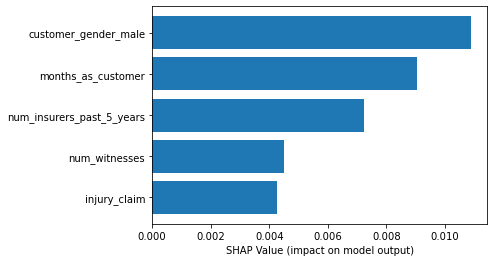

In [25]:
if "clarify_expl_job_name" in locals():
    s3_client.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/explainability/analysis.json",
        Filename="clarify_output/explainability/analysis.json",
    )
    print(f"Downloaded analysis from previous Clarify job: {clarify_expl_job_name}\n")
else:
    print(f"Loading pre-generated analysis file...\n")

with open("clarify_output/explainability/analysis.json", "r") as f:
    analysis_result = json.load(f)

shap_values = pd.DataFrame(analysis_result["explanations"]["kernel_shap"]["label0"])
importances = shap_values["global_shap_values"].sort_values(ascending=False)
fig, ax = plt.subplots()
n = 5
y_pos = np.arange(n)
importance_scores = importances.values[:n]
y_label = importances.index[:n]
ax.barh(y_pos, importance_scores, align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
ax.invert_yaxis()
ax.set_xlabel("SHAP Value (impact on model output)");

To see the autogenerated SageMaker Clarify report, run the following code and use the output link to open the report.

In [26]:
from IPython.display import FileLink, FileLinks

display(
    "Click link below to view the SageMaker Clarify report", FileLink("clarify_output/report.pdf")
)

'Click link below to view the SageMaker Clarify report'

/home/ec2-user/SageMaker/amazon-sagemaker-examples/end_to_end/fraud_detection/clarify_output/report.pdf

### What is SHAP?
SHAP is the method used for calculating explanations in this solution.
Unlike other feature attribution methods, such as single feature
permutation, SHAP tries to disentangle the effect of a single feature by
looking at all possible combinations of features.

[SHAP](https://github.com/slundberg/shap) (Lundberg et al. 2017) stands
for SHapley Additive exPlanations. 'Shapley' relates to a game theoretic
concept called [Shapley
values](https://en.wikipedia.org/wiki/Shapley_value) that is used to
create the explanations. A Shapley value describes the marginal
contribution of each 'player' when considering all possible 'coalitions'.
Using this in a machine learning context, a Shapley value  describes the
marginal contribution of each feature when considering all possible sets
of features. 'Additive' relates to the fact that these Shapley values can
be summed together to give the final model prediction.

As an example, we might start off with a baseline credit default risk of
10%. Given a set of features, we can calculate the Shapley value for each
feature. Summing together all the Shapley values, we might obtain a
cumulative value of +30%. Given the same set of features, we therefore
expect our model to return a credit default risk of 40% (i.e. 10% + 30%).

## Create Model Package for the Trained Model
----


#### Create and upload second model metrics report

In [27]:
model_metrics_report = {"binary_classification_metrics": {}}
for metric in training_job_2_info["FinalMetricDataList"]:
    stat = {metric["MetricName"]: {"value": metric["Value"], "standard_deviation": "NaN"}}
    model_metrics_report["binary_classification_metrics"].update(stat)

with open("training_metrics.json", "w") as f:
    json.dump(model_metrics_report, f)

metrics_s3_key = (
    f"{prefix}/training_jobs/{training_job_2_info['TrainingJobName']}/training_metrics.json"
)
s3_client.upload_file(Filename="training_metrics.json", Bucket=bucket, Key=metrics_s3_key)

#### Define inference specification

In [28]:
mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_job_2_info["AlgorithmSpecification"]["TrainingImage"],
    supports_gpu=False,
    supported_content_types=["text/csv"],
    supported_mime_types=["text/csv"],
)

mp_inference_spec["InferenceSpecification"]["Containers"][0]["ModelDataUrl"] = training_job_2_info[
    "ModelArtifacts"
]["S3ModelArtifacts"]

#### Define model metrics

In [29]:
model_metrics = {
    "ModelQuality": {
        "Statistics": {
            "ContentType": "application/json",
            "S3Uri": f"s3://{bucket}/{metrics_s3_key}",
        }
    },
    "Bias": {
        "Report": {
            "ContentType": "application/json",
            "S3Uri": f"{explainability_output_path}/analysis.json",
        }
    },
}

#### Register second model package to Model Package Group

In [30]:
mpg_name = prefix
mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "XGBoost classifier to detect insurance fraud with SMOTE.",
    "ModelApprovalStatus": "PendingManualApproval",
    "ModelMetrics": model_metrics,
}

mp_input_dict.update(mp_inference_spec)
mp2_response = sagemaker_boto_client.create_model_package(**mp_input_dict)
mp2_arn = mp2_response["ModelPackageArn"]

#### Check status of model package creation

In [31]:
mp_info = sagemaker_boto_client.describe_model_package(
    ModelPackageName=mp2_response["ModelPackageArn"]
)
mp_status = mp_info["ModelPackageStatus"]

while mp_status not in ["Completed", "Failed"]:
    time.sleep(5)
    mp_info = sagemaker_boto_client.describe_model_package(
        ModelPackageName=mp2_response["ModelPackageArn"]
    )
    mp_status = mp_info["ModelPackageStatus"]
    print(f"model package status: {mp_status}")
print(f"model package status: {mp_status}")

model package status: Completed


### View both models in the registry

In [32]:
sagemaker_boto_client.list_model_packages(ModelPackageGroupName=mpg_name)["ModelPackageSummaryList"]

[{'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 14,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:326383828736:model-package/fraud-detect-demo/14',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
  'CreationTime': datetime.datetime(2022, 10, 3, 16, 32, 26, 475000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'},
 {'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 13,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:326383828736:model-package/fraud-detect-demo/13',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
  'CreationTime': datetime.datetime(2022, 10, 3, 16, 9, 54, 686000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'Approved'},
 {'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 12,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:326

<a id ='deploy'> </a>

## Architecture: Deploy and Serve Model
----

Now that we have trained a model, we can deploy and serve it. The follwoing picture shows the architecture for doing so.

![train-assess-tune-register](./images/e2e-3-pipeline-v3b.png)

In [33]:
# variables used for parameterizing the notebook run
endpoint_name = f"{model_2_name}-endpoint"
endpoint_instance_count = 1
endpoint_instance_type = "ml.m4.xlarge"

predictor_instance_count = 1
predictor_instance_type = "ml.c5.xlarge"
batch_transform_instance_count = 1
batch_transform_instance_type = "ml.c5.xlarge"

## Deploy an Approved Model and Make a Prediction
----

#### Approve the second model
In the real-life MLOps lifecycle, a model package gets approved after evaluation by data scientists, subject matter experts and auditors.

In [34]:
second_model_package = sagemaker_boto_client.list_model_packages(ModelPackageGroupName=mpg_name)[
    "ModelPackageSummaryList"
][0]
model_package_update = {
    "ModelPackageArn": second_model_package["ModelPackageArn"],
    "ModelApprovalStatus": "Approved",
}

update_response = sagemaker_boto_client.update_model_package(**model_package_update)

#### Create an endpoint config and an endpoint
Deploy the endpoint. This might take about 8minutes.

In [35]:
primary_container = {"ModelPackageName": second_model_package["ModelPackageArn"]}
endpoint_config_name = f"{model_2_name}-endpoint-config"
existing_configs = len(
    sagemaker_boto_client.list_endpoint_configs(NameContains=endpoint_config_name, MaxResults=30)[
        "EndpointConfigs"
    ]
)

if existing_configs == 0:
    create_ep_config_response = sagemaker_boto_client.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "InstanceType": endpoint_instance_type,
                "InitialVariantWeight": 1,
                "InitialInstanceCount": endpoint_instance_count,
                "ModelName": model_2_name,
                "VariantName": "AllTraffic",
            }
        ],
    )

In [36]:
def delete_endpoint_if_exists(sagemaker_boto_client, endpoint_name):
    existing_endpoints = sagemaker_boto_client.list_endpoints(
        NameContains=endpoint_name, MaxResults=30
    )["Endpoints"]
    if existing_endpoints:
        delete_endpoint_response = sagemaker_boto_client.delete_endpoint(
            EndpointName=endpoint_name
        )
    while True:
        existing_endpoints = sagemaker_boto_client.list_endpoints(
            NameContains=endpoint_name, MaxResults=30
        )["Endpoints"]
        if not existing_endpoints:
            break
        else:
            print("Waiting for {} endpoint deletion".format(endpoint_name))
            time.sleep(5)

delete_endpoint_if_exists(sagemaker_boto_client, endpoint_name)

create_endpoint_response = sagemaker_boto_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=endpoint_name)
endpoint_status = endpoint_info["EndpointStatus"]

while endpoint_status == "Creating":
    endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=endpoint_name)
    endpoint_status = endpoint_info["EndpointStatus"]
    print("Endpoint status:", endpoint_status)
    if endpoint_status == "Creating":
        time.sleep(60)

Waiting for fraud-detect-demo-xgboost-post-smote-endpoint endpoint deletion
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: InService


## Run Predictions on Claims
----

<a id='predictor'> </a>

### Create a predictor

In [37]:
predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name, sagemaker_session=sagemaker_session
)

### Sample a claim from the test data

In [38]:
dataset = pd.read_csv("data/dataset.csv")
train = dataset.sample(frac=0.8, random_state=0)
test = dataset.drop(train.index)
sample_policy_id = int(test.sample(1)["policy_id"])

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 4997
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       1000 non-null   int64  
 1   policy_id                        1000 non-null   int64  
 2   num_vehicles_involved            1000 non-null   int64  
 3   collision_type_side              1000 non-null   int64  
 4   auto_year                        1000 non-null   int64  
 5   policy_annual_premium            1000 non-null   int64  
 6   authorities_contacted_police     1000 non-null   int64  
 7   policy_liability                 1000 non-null   int64  
 8   num_injuries                     1000 non-null   int64  
 9   incident_type_theft              1000 non-null   int64  
 10  customer_gender_male             1000 non-null   int64  
 11  collision_type_front             1000 non-null   int64  
 12  total_claim_amount  

### Get Multiple Claims

In [40]:
dataset = pd.read_csv("./data/claims_customer.csv")
col_order = ["fraud"] + list(dataset.drop(["fraud", "Unnamed: 0", "policy_id"], axis=1).columns)
col_order

['fraud',
 'num_vehicles_involved',
 'collision_type_side',
 'auto_year',
 'policy_annual_premium',
 'authorities_contacted_police',
 'policy_liability',
 'num_injuries',
 'incident_type_theft',
 'customer_gender_male',
 'collision_type_front',
 'total_claim_amount',
 'months_as_customer',
 'customer_education',
 'policy_state_wa',
 'incident_day',
 'driver_relationship_na',
 'num_insurers_past_5_years',
 'incident_dow',
 'policy_state_az',
 'incident_month',
 'customer_gender_female',
 'driver_relationship_spouse',
 'driver_relationship_child',
 'incident_type_collision',
 'policy_state_ca',
 'policy_state_id',
 'incident_severity',
 'vehicle_claim',
 'authorities_contacted_fire',
 'collision_type_na',
 'authorities_contacted_none',
 'customer_age',
 'num_witnesses',
 'injury_claim',
 'policy_deductable',
 'policy_state_or',
 'driver_relationship_self',
 'incident_type_breakin',
 'policy_state_nv',
 'police_report_available',
 'incident_hour',
 'driver_relationship_other',
 'num_claim

In [41]:
col_order

['fraud',
 'num_vehicles_involved',
 'collision_type_side',
 'auto_year',
 'policy_annual_premium',
 'authorities_contacted_police',
 'policy_liability',
 'num_injuries',
 'incident_type_theft',
 'customer_gender_male',
 'collision_type_front',
 'total_claim_amount',
 'months_as_customer',
 'customer_education',
 'policy_state_wa',
 'incident_day',
 'driver_relationship_na',
 'num_insurers_past_5_years',
 'incident_dow',
 'policy_state_az',
 'incident_month',
 'customer_gender_female',
 'driver_relationship_spouse',
 'driver_relationship_child',
 'incident_type_collision',
 'policy_state_ca',
 'policy_state_id',
 'incident_severity',
 'vehicle_claim',
 'authorities_contacted_fire',
 'collision_type_na',
 'authorities_contacted_none',
 'customer_age',
 'num_witnesses',
 'injury_claim',
 'policy_deductable',
 'policy_state_or',
 'driver_relationship_self',
 'incident_type_breakin',
 'policy_state_nv',
 'police_report_available',
 'incident_hour',
 'driver_relationship_other',
 'num_claim

### Pull customer data and format the datapoint
When a customer submits an insurance claim online for instant approval, the insurance company will need to pull customer-specific data. You can do it either using the customer data we have stored in a CSV files or an online feature store to add to the claim data. The pulled data will serve as input for a model prediction.

Then, the datapoint must match the exact input format as the model was trained--with all features in the correct order. In this example, the `col_order` variable was saved when you created the train and test datasets earlier in the guide.

In [42]:
sample_policy_id = int(test.sample(1)["policy_id"])
pull_from_feature_store = False

if pull_from_feature_store:
    customers_response = featurestore_runtime.get_record(
        FeatureGroupName=customers_fg_name, RecordIdentifierValueAsString=str(sample_policy_id)
    )

    customer_record = customers_response["Record"]
    customer_df = pd.DataFrame(customer_record).set_index("FeatureName")

    claims_response = featurestore_runtime.get_record(
        FeatureGroupName=claims_fg_name, RecordIdentifierValueAsString=str(sample_policy_id)
    )

    claims_record = claims_response["Record"]
    claims_df = pd.DataFrame(claims_record).set_index("FeatureName")

    blended_df = pd.concat([claims_df, customer_df]).loc[col_order].drop("fraud")
else:
    customer_claim_df = dataset[dataset["policy_id"] == sample_policy_id].sample(1)
    blended_df = customer_claim_df.loc[:, col_order].drop("fraud", axis=1).T.reset_index()
    blended_df.columns = ["FeatureName", "ValueAsString"]

data_input = ",".join([str(x) for x in blended_df["ValueAsString"]])
data_input

'1.0,1.0,2014.0,3000.0,0.0,2.0,0.0,0.0,1.0,0.0,12000.0,161.0,0.0,0.0,20.0,0.0,1.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,12000.0,0.0,0.0,1.0,44.0,0.0,0.0,750.0,0.0,1.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0'

### Make prediction

In [43]:
results = predictor.predict(data_input, initial_args={"ContentType": "text/csv"})
prediction = json.loads(results)
print(f"Probablitity the claim from policy {int(sample_policy_id)} is fraudulent:", prediction)

Probablitity the claim from policy 2839 is fraudulent: 0.03418382629752159
